In [13]:
import torch
import pandas as pd
from PIL import Image
from os.path import join
import torchvision.transforms as tf
import torchvision
import joblib
import numpy as np

In [2]:
data_path = "../batches/malmo.data"
img_path = "/mnt/Xtension/CMU/visdial/visdial_malmo_data/"

In [3]:
data = joblib.load(data_path)
df = data["df"]
mappings = data["mappings"]

In [4]:
df.head()

,image_name,description,question,answer,bounding_box
0,map_2_inside_env_001806.png,<sos> there is a partial view of the room from...,"[<sos> what is present in the room ? <eos>, <s...","[<sos> there is nothing present in the room , ...","[{""height"":422,""label"":""Door"",""left"":251,""top""..."
1,map_2_inside_env_001063.png,<sos> room with furniture and a victim <eos>,"[<sos> is there a painting <eos>, <sos> does t...",[<sos> yes there is a painting on the wall <eo...,"[{""height"":63,""label"":""Painting"",""left"":396,""t..."
2,map_1_inside_env_004857.png,<sos> there is a corridor with a door and a fe...,"[<sos> is the door open ? <eos>, <sos> how man...","[<sos> yes , the door is open . <eos>, <sos> t...","[{""height"":315,""label"":""Door"",""left"":400,""top""..."
3,map_2_inside_env_002306.png,<sos> a door in a corridor . <eos>,"[<sos> is there fire in the corridor ? <eos>, ...","[<sos> no , there is no fire in the corridor ....","[{""height"":142,""label"":""Door"",""left"":213,""top""..."
4,map_1_inside_env_002893.png,<sos> room with a bookshelf and a yellow victi...,"[<sos> is there a door <eos>, <sos> can a leve...","[<sos> no door visible <eos>, <sos> no lever c...","[{""height"":274,""label"":""Bookshelf"",""left"":0,""t..."


In [5]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, im_path, im_transform, w2i):
        self.df = df
        self.im_path = im_path
        self.im_transform = im_transform
        self.w2i = w2i
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(join(img_path, row["image_name"]))
        im = self.im_transform(im)
        
        description = row["description"]
        questions = row["question"]
        answers = row["answer"]
        
        questions, qlens = self.__words2index(questions, padStart=True)
        answers, alens = self.__words2index(answers, padStart=False)
        return ((np.array(questions), np.array(qlens)), im), (np.array(answers), np.array(alens))
     
    def __words2index(self, sentences, padStart=True):
        sentence_lens = []
        indexed_sentences = []
        for sentence in sentences:
            sent = [self.w2i[word] for word in sentence.split(" ")]
            indexed_sentences.append(sent)
            sentence_lens.append(len(sent))
        
        max_len = max(sentence_lens)
        if padStart:
            indexed_sentences = [[self.w2i["<pad>"]] * (max_len - len(sent)) + sent for sent in indexed_sentences]
        else:
            indexed_sentences = [sent + [self.w2i["<pad>"]] * (max_len - len(sent)) for sent in indexed_sentences]
        return indexed_sentences, sentence_lens

In [6]:
transform = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor(),
    tf.Normalize((0, 0, 0), (1, 1, 1)),
])

In [7]:
dataset = Dataset(df, img_path, transform, mappings["w2i"])

In [8]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

## Training

In [239]:
import model
import importlib

In [240]:
importlib.reload(model)

<module 'model' from '/home/aviral/Documents/MCDS/Capstone/visdial/dialog-system/code/model.py'>

In [241]:
DEVICE = "cuda"

In [242]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
for param in feature_extractor.parameters():
    param.requires_grad = False
feature_extractor.fc = torch.nn.Linear(512, 512)

In [243]:
feature_extractor = feature_extractor.to(DEVICE)

In [244]:
model = model.VisualDialog(feature_extractor, len(mappings["w2i"]), DEVICE).to(DEVICE)

In [245]:
optimizer = torch.optim.Adam(list(model.feature_extractor.fc.parameters()) + 
                             list(model.question_encoder.parameters()) + 
                             list(model.question_keys.parameters()) + 
                             list(model.question_values.parameters()) +
                             list(model.answer_decoder.parameters()) + 
                             list(model.answer_linear.parameters()),
                             lr=1e-4
                            )

In [246]:
LOAD = True
if LOAD:
    model.load_state_dict(torch.load("../visdial.model"))

In [168]:
def train(net, optimizer, epoches):
    net.train()
    loss_func = torch.nn.CrossEntropyLoss()
    for e in range(epoches):
        total_loss = 0.
        for bno, (((questions, qlens), im), (answers, alens)) in enumerate(data_loader):
            questions = questions[0].to(DEVICE)
            qlens = qlens[0].to(DEVICE)
            im = im[0].to(DEVICE)
            answers = answers[0].to(DEVICE)
            alens = alens[0].to(DEVICE)
            
            optimizer.zero_grad()
            op = model(questions, answers, alens, im)

            ans = torch.cat([answers[:, 1:], torch.zeros((answers.size(0), 1)).long().to(DEVICE)], dim=-1)
            loss = 0.
            for i, l in enumerate(alens):
                true = ans[i].unsqueeze(0)
                loss += loss_func(op[i].unsqueeze(0).permute(0, 2, 1), true[:, :l]) / (l - 1)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        torch.save(model.state_dict(), "../visdial.model")
        print("Epoch", e+1, total_loss / len(data_loader))
        print("------------------")

In [66]:
train(model, optimizer, 10000)

/home/aviral/Documents/MCDS/Capstone/visdial/dialog-system/code/model.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = nn.functional.softmax(energy) # (TIME_STEPS)


Epoch 1 1.0452828954269247
------------------
Epoch 2 0.9661263544263878
------------------
Epoch 3 0.9157336440876247
------------------
Epoch 4 0.868422890854318
------------------
Epoch 5 0.8327237639909353
------------------
Epoch 6 0.790398234698346
------------------
Epoch 7 0.7529821171750867
------------------
Epoch 8 0.7216478431733643
------------------
Epoch 9 0.6976642826708351
------------------
Epoch 10 0.6665097133415502
------------------
Epoch 11 0.6431784813966208
------------------
Epoch 12 0.6105882838610711
------------------
Epoch 13 0.590281488782749
------------------
Epoch 14 0.5582380489847525
------------------
Epoch 15 0.5399489965804709
------------------
Epoch 16 0.5571692656210767
------------------
Epoch 17 0.5071813450535623
------------------
Epoch 18 0.485916650634471
------------------
Epoch 19 0.46323199998738807
------------------
Epoch 20 0.44699569320593907
------------------
Epoch 21 0.43933621986307264
------------------
Epoch 22 0.489767935460

Epoch 171 0.016568085029427856
------------------
Epoch 172 0.015431827850989066
------------------
Epoch 173 0.019288220565517177
------------------
Epoch 174 0.0177769818268333
------------------
Epoch 175 0.015742735171487568
------------------
Epoch 176 0.015722827648290156
------------------
Epoch 177 0.016456537529456097
------------------
Epoch 178 0.015540138663694724
------------------
Epoch 179 0.02514681405567884
------------------
Epoch 180 0.02397920885615475
------------------
Epoch 181 0.020575903225758745
------------------
Epoch 182 0.01595913935999284
------------------
Epoch 183 0.014622377335177678
------------------
Epoch 184 0.014068747671570429
------------------
Epoch 185 0.01835304535549168
------------------
Epoch 186 0.017003584537019563
------------------
Epoch 187 0.015743157861383285
------------------
Epoch 188 0.015018461220123997
------------------
Epoch 189 0.01421891451942
------------------
Epoch 190 0.015565707116107157
------------------
Epoch 191 

Epoch 336 0.011199499194356954
------------------
Epoch 337 0.011273877453765258
------------------
Epoch 338 0.010203870100431084
------------------
Epoch 339 0.010485095910671663
------------------
Epoch 340 0.01112803831773174
------------------
Epoch 341 0.011149515336178521
------------------
Epoch 342 0.010614646456726804
------------------
Epoch 343 0.01094832011295967
------------------
Epoch 344 0.009608438899918631
------------------
Epoch 345 0.01287969287853237
------------------
Epoch 346 0.019431330277900376
------------------
Epoch 347 0.013938461971601493
------------------
Epoch 348 0.013493396638931869
------------------
Epoch 349 0.010911619828952897
------------------
Epoch 350 0.010799731207332183
------------------
Epoch 351 0.010789103709331409
------------------
Epoch 352 0.010662194523453164
------------------
Epoch 353 0.011560662021414222
------------------
Epoch 354 0.01043366431447912
------------------
Epoch 355 0.010631152100573466
------------------
Epoc

Epoch 501 0.007874444093468493
------------------
Epoch 502 0.008056562038350458
------------------
Epoch 503 0.00947790811858987
------------------
Epoch 504 0.007505374248489161
------------------
Epoch 505 0.007245975722773763
------------------
Epoch 506 0.007711249328452148
------------------
Epoch 507 0.009045340339780966
------------------
Epoch 508 0.007115660863694838
------------------
Epoch 509 0.007084246547063645
------------------
Epoch 510 0.008153137823235857
------------------
Epoch 511 0.007963702151748174
------------------
Epoch 512 0.006603003764700212
------------------
Epoch 513 0.009214415222446199
------------------
Epoch 514 0.018396929737718892
------------------
Epoch 515 0.03971763900573001
------------------
Epoch 516 0.010863179411699536
------------------
Epoch 517 0.007411464358978916
------------------
Epoch 518 0.006609418252482123
------------------
Epoch 519 0.0074746773495676985
------------------
Epoch 520 0.006923436066766199
------------------
E

Epoch 666 0.004280023244263713
------------------
Epoch 667 0.0043620862159854355
------------------
Epoch 668 0.003961629480660876
------------------
Epoch 669 0.004636910561683595
------------------
Epoch 670 0.003531304790712744
------------------
Epoch 671 0.003976195269217904
------------------
Epoch 672 0.0034739835952892254
------------------
Epoch 673 0.004062430070036972
------------------
Epoch 674 0.004077421362932163
------------------
Epoch 675 0.0031583483657554525
------------------
Epoch 676 0.004723556984398731
------------------
Epoch 677 0.004269537197622531
------------------
Epoch 678 0.011422634862755352
------------------
Epoch 679 0.014536773028923814
------------------
Epoch 680 0.012042827683786542
------------------
Epoch 681 0.00951365345671052
------------------
Epoch 682 0.005863669984469974
------------------
Epoch 683 0.004259293639194315
------------------
Epoch 684 0.0046264385213495495
------------------
Epoch 685 0.00306931887820152
-----------------

KeyboardInterrupt: 

In [94]:
torch.save(model.state_dict(), "../visdial.model")

In [334]:
def eval(net):
    net.eval()
    for bno, (((questions, qlens), im), (answers, alens)) in enumerate(data_loader):
        questions = questions[0].to(DEVICE)
        qlens = qlens[0].to(DEVICE)
        im = im[0].to(DEVICE)
        answers = answers[0].to(DEVICE)
        alens = alens[0].to(DEVICE)
        
        results = []
        for qno in range(len(questions)):
            question = questions[qno]
            if qno == 0:
                reset = True
            else:
                reset = False
            op = model.predict(question.unsqueeze(0), im, mappings, reset=reset)
            results.append((question.cpu().numpy(), op, answers[qno].cpu().numpy()))
        return results, im
def display_results(res, mappings):
    def parse_sent(sent):
        s = []
        for word in sent:
            if word == mappings["w2i"]["<pad>"] or word == mappings["w2i"]["<eos>"] or word == mappings["w2i"]["<sos>"]:
                continue
            s.append(word)
        return s
    
    to_pil = tf.Compose([tf.ToPILImage(), tf.Resize((400, 400))])
    display(to_pil(res[1].cpu()))
    for i, (q, a, t) in enumerate(res[0]):
        pq = parse_sent(q)
        pa = parse_sent(a)
        pt = parse_sent(t)

        print("QNo: {}".format(i+1))
        print("Q:", " ".join([mappings["i2w"][i] for i in pq]))
        print("A:", " ".join([mappings["i2w"][i] for i in pa]))
#         print("GT:", " ".join([mappings["i2w"][i] for i in pt]))        

In [339]:
results = eval(model)

/home/aviral/Documents/MCDS/Capstone/visdial/dialog-system/code/model.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = nn.functional.softmax(energy) # (TIME_STEPS)


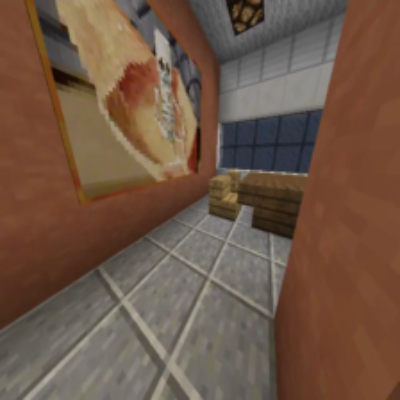

QNo: 1
Q: is there a victim
A: no victim can be seen
QNo: 2
Q: are there doors present
A: can not see a room
QNo: 3
Q: are there windows
A: yes windows are visible
QNo: 4
Q: is there a painting hanging on the wall
A: yes a painting can be seen
QNo: 5
Q: is there some furniture
A: yes furniture is visible in front
QNo: 6
Q: is the painting close
A: somewhat
QNo: 7
Q: is there a torch
A: no torch can be seen
QNo: 8
Q: is fire visible
A: can not see a fire painting
QNo: 9
Q: describe the scene
A: a room with a large window and furniture .


In [340]:
display_results(results, mappings)